loading annotations into memory...
Done (t=20.23s)
creating index...
index created!


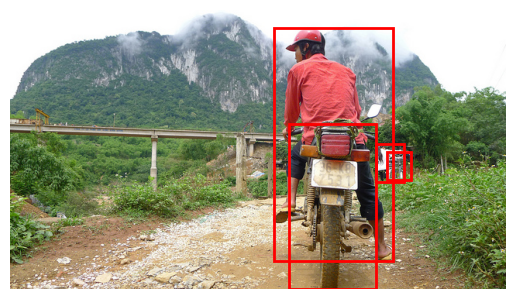

In [ ]:
import json
import os
import torch
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
from torchvision.transforms import functional as F
from PIL import Image

# Set the path to your COCO data
image_dir = "/data/coco2017/train2017"  # Update this path to the folder where train images are stored
annotation_file = "/data/coco2017/annotations/instances_train2017.json"  # Update this path to the instances_train2017.json file

# Load COCO annotations
coco = COCO(annotation_file)

# Load a random image and display it
img_id = coco.getImgIds()[0]  # Get the ID of the first image
img_info = coco.loadImgs(img_id)[0]
image_path = os.path.join(image_dir, img_info['file_name'])

# Read image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Get annotations for the image
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

# Display image with annotations
plt.imshow(img_rgb)
ax = plt.gca()
for ann in anns:
    bbox = ann['bbox']
    x, y, w, h = bbox
    ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2))
plt.axis('off')
plt.show()


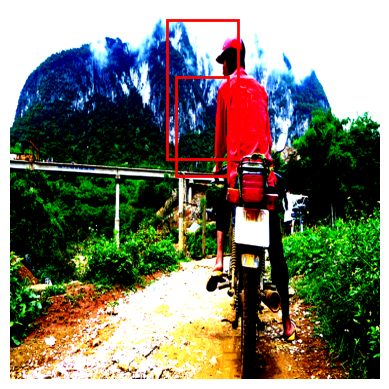

In [30]:
from torchvision import transforms

# Define image transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((800, 800)),  # Resize to fit model input size (DETR usually uses 800x800)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

# Preprocess image and annotations
def preprocess_data(image, anns, img_info):
    # Apply the image transform
    image = transform(image)

    # Convert bounding boxes to the format (x_min, y_min, x_max, y_max)
    boxes = []
    labels = []
    for ann in anns:
        bbox = ann['bbox']
        x_min, y_min, width, height = bbox
        x_max = x_min + width
        y_max = y_min + height
        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(ann['category_id'])

    # Convert boxes and labels to tensors
    boxes = torch.tensor(boxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)

    return image, boxes, labels

# Test preprocessing on one image
image = cv2.imread(image_path)  # Read image again using OpenCV
image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert to PIL image
image_transformed, boxes, labels = preprocess_data(image_pil, anns, img_info)

# Visualize the transformed image with bounding boxes
plt.imshow(image_transformed.permute(1, 2, 0))  # Change dimension order for plotting
ax = plt.gca()
for bbox in boxes:
    ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, color='red', linewidth=2))
plt.axis('off')
plt.show()


In [ ]:
class CocoDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_file)
        self.image_ids = self.coco.getImgIds()
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Preprocess the image and annotations
        if self.transform:
            img, boxes, labels = preprocess_data(img, anns, img_info)

        return img, boxes, labels

# Create dataset and dataloaders
dataset = CocoDataset(image_dir="/data/coco-2017-dataset/coco2017/train2017", 
                      annotation_file="/data/coco2017/annotations/instances_train2017.json", 
                      transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Test the DataLoader
for images, boxes, labels in dataloader:
    # `images` is a tuple, so we need to extract the first element for the actual image tensor
    images = torch.stack(images, dim=0)  # Stack the images into a single tensor

    print(images.shape)  # Images shape: [batch_size, channels, height, width]
    print([box.shape for box in boxes])  # List of box shapes for each image
    break  # Just testing with one batch

loading annotations into memory...
Done (t=19.94s)
creating index...
index created!
torch.Size([4, 3, 800, 800])
[torch.Size([2, 4]), torch.Size([16, 4]), torch.Size([7, 4]), torch.Size([11, 4])]


In [ ]:
torch.save(model.state_dict(), "/models/detr_model.pth")
